In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from cooler.util import binnify
import pyranges as pr
import uuid

# Load data

In [3]:
#file_path = "/groups/gerlich/experiments/Experiments_005400/005484/sequencing_results/merged_contacts/DpnII_run02_hg19_unphased.triplets.parquet"
file_path = "DpnII_run02_hg19_unphased.triplets.parquet"

In [4]:
triplets = dd.read_parquet(file_path)

In [5]:
triplets

,read_name,read_length,chrom_1,start_1,end_1,mapping_quality_1,align_score_1,align_base_qscore_1,is_labelled_1,sister_identity_1,chrom_2,start_2,end_2,mapping_quality_2,align_score_2,align_base_qscore_2,is_labelled_2,sister_identity_2,chrom_3,start_3,end_3,mapping_quality_3,align_score_3,align_base_qscore_3,is_labelled_3,sister_identity_3
npartitions=67,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,int64,object,int64,int64,int64,int64,int64,bool,object,object,int64,int64,int64,int64,int64,bool,object,object,int64,int64,int64,int64,int64,bool,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
triplets.columns

Index(['read_name', 'read_length', 'chrom_1', 'start_1', 'end_1',
       'mapping_quality_1', 'align_score_1', 'align_base_qscore_1',
       'is_labelled_1', 'sister_identity_1', 'chrom_2', 'start_2', 'end_2',
       'mapping_quality_2', 'align_score_2', 'align_base_qscore_2',
       'is_labelled_2', 'sister_identity_2', 'chrom_3', 'start_3', 'end_3',
       'mapping_quality_3', 'align_score_3', 'align_base_qscore_3',
       'is_labelled_3', 'sister_identity_3'],
      dtype='object')

# Subset on 2 cis one trans

# Sort that 2 cis or first

In [7]:
is_cis_trans = (
    ((triplets.sister_identity_1 == triplets.sister_identity_2) & (triplets.sister_identity_1 != triplets.sister_identity_3)) |
    ((triplets.sister_identity_1 == triplets.sister_identity_3) & (triplets.sister_identity_1 != triplets.sister_identity_2)) |
    ((triplets.sister_identity_2 == triplets.sister_identity_3) & (triplets.sister_identity_1 != triplets.sister_identity_2))
)
is_cis_cis_trans = (
    (triplets.sister_identity_1 == triplets.sister_identity_2) & (triplets.sister_identity_1 != triplets.sister_identity_3)
)
is_cis_trans_cis = (
    (triplets.sister_identity_1 == triplets.sister_identity_3) & (triplets.sister_identity_1 != triplets.sister_identity_2)
)
is_trans_cis_cis = (
    (triplets.sister_identity_2 == triplets.sister_identity_3) & (triplets.sister_identity_1 != triplets.sister_identity_2)
)

In [8]:
sister_triplets = triplets.loc[is_cis_trans, ["read_name","chrom_1", "start_1", "end_1", "chrom_2", "start_2", "end_2", "chrom_3", "start_3", "end_3"]]

In [9]:
## TODO Testing if this concat works as I believe or does it realign the columns
d = {'col1': [1, 2, 3, 4], 'col2': [5, 6, 7, 8]}
dfd = dd.from_pandas(pd.DataFrame(data=d), npartitions=2)
e = {'col1': [1.1, 2.2, 3.3, 4.4], 'col2': [5.5, 6.6, 7.7, 8.8]}
dfe = dd.from_pandas(pd.DataFrame(data=e), npartitions=2)
#dfe_flip = dfe.loc[dfe.col1 != 0, ["col2", "col1"]]
#dfe_flip = dfe_flip.rename(columns={"col1": "col2", "col2": "col1"})
#dfe_flip = dfe.rename(columns={"col1": "col2", "col2": "col1"})
dall_h = [dfd,dfe.rename(columns={"col1": "col2", "col2": "col1"})]
dall = dd.concat(dall_h, axis=0)
dall.compute()

,col1,col2
0,1.0,5.0
1,2.0,6.0
2,3.0,7.0
3,4.0,8.0
0,5.5,1.1
1,6.6,2.2
2,7.7,3.3
3,8.8,4.4


In [10]:
# o.k the reorder is not necessary
sister_triplets_cis_cis_trans = triplets.loc[is_cis_cis_trans, ["read_name","chrom_1", "start_1", "end_1", "chrom_2", "start_2", "end_2", "chrom_3", "start_3", "end_3"]]
sister_triplets_cis_trans_cis = triplets.loc[is_cis_trans_cis, ["read_name","chrom_1", "start_1", "end_1", "chrom_3", "start_3", "end_3", "chrom_2", "start_2", "end_2"]]
sister_triplets_trans_cis_cis = triplets.loc[is_trans_cis_cis, ["read_name", "chrom_2", "start_2", "end_2", "chrom_3", "start_3", "end_3","chrom_1", "start_1", "end_1"]]
# this does the flipping
sister_triplets_cis_trans_cis_flipped = sister_triplets_cis_trans_cis.rename(columns={"chrom_2": "chrom_3","chrom_3": "chrom_2", "start_2": "start_3","start_3": "start_2", "end_2": "end_3", "end_3": "end_2"})
sister_triplets_trans_cis_cis_flipped = sister_triplets_trans_cis_cis.rename(columns={"chrom_1": "chrom_3","chrom_3": "chrom_1", "start_1": "start_3","start_3": "start_1", "end_1": "end_3", "end_3": "end_1"})
sister_triplets_sorted_helper = [sister_triplets_cis_cis_trans,sister_triplets_cis_trans_cis_flipped,sister_triplets_trans_cis_cis_flipped]
sister_triplets_sorted = dd.concat(sister_triplets_sorted_helper, axis=0)
sister_triplets_sorted

,read_name,chrom_1,start_1,end_1,chrom_2,start_2,end_2,chrom_3,start_3,end_3
npartitions=201,,,,,,,,,,
,object,object,int64,int64,object,int64,int64,object,int64,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [11]:
sister_triplets

,read_name,chrom_1,start_1,end_1,chrom_2,start_2,end_2,chrom_3,start_3,end_3
npartitions=67,,,,,,,,,,
,object,object,int64,int64,object,int64,int64,object,int64,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [12]:
sister_triplets_w_midpoint = sister_triplets.assign(pos_1=lambda df: (df.start_1 + df.end_1)//2)\
                                            .assign(pos_2=lambda df: (df.start_2 + df.end_2)//2)\
                                            .assign(pos_3=lambda df: (df.start_3 + df.end_3)//2)\
                                            .drop(["start_1", "end_1", "start_2", "end_2", "start_3", "end_3"], axis=1)

In [13]:
sister_triplets_sorted_w_midpoint = sister_triplets_sorted.assign(pos_1=lambda df: (df.start_1 + df.end_1)//2)\
                                            .assign(pos_2=lambda df: (df.start_2 + df.end_2)//2)\
                                            .assign(pos_3=lambda df: (df.start_3 + df.end_3)//2)\
                                            .drop(["start_1", "end_1", "start_2", "end_2", "start_3", "end_3"], axis=1)

In [14]:
sister_triplets_w_midpoint

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
npartitions=67,,,,,,,
,object,object,object,object,int64,int64,int64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [15]:
sister_triplets_sorted_w_midpoint

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
npartitions=201,,,,,,,
,object,object,object,object,int64,int64,int64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [16]:
test = sister_triplets_w_midpoint.compute()
test

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
0,0007f55e-45c5-4402-ba9c-77a30b2656e8,chr5,chr20,chr5,141613130,62736893,141383565
5,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472729
6,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105476219
7,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472113
8,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr1,105522273,154428199,154429838
...,...,...,...,...,...,...,...
279316,fff0389c-f38b-4bbf-8413-21807cdc9453,chr3,chr16,chr3,20073858,82269806,20080541
279320,fff0389c-f38b-4bbf-8413-21807cdc9453,chr16,chr3,chr3,82269806,33678654,33676404
279321,fff0389c-f38b-4bbf-8413-21807cdc9453,chr16,chr3,chr3,82269806,33678654,20080541
279322,fff0389c-f38b-4bbf-8413-21807cdc9453,chr16,chr3,chr3,82269806,33676404,20080541


In [17]:
test_sorted = sister_triplets_sorted_w_midpoint.compute()
test_sorted

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
11,000d9b90-0949-425e-af86-966a366d3129,chr3,chr3,chr1,105522273,105472729,154429838
13,000d9b90-0949-425e-af86-966a366d3129,chr3,chr3,chr1,105522273,105476219,154429838
14,000d9b90-0949-425e-af86-966a366d3129,chr3,chr3,chr1,105522273,105472113,154429838
22,000d9b90-0949-425e-af86-966a366d3129,chr3,chr3,chr1,105472729,105476219,154429838
23,000d9b90-0949-425e-af86-966a366d3129,chr3,chr3,chr1,105472729,105472113,154429838
...,...,...,...,...,...,...,...
279261,ffe632cc-9efa-498c-9122-0b9208536d47,chr5,chr5,chr5,31265098,23416969,31046253
279262,ffe632cc-9efa-498c-9122-0b9208536d47,chr5,chr5,chr5,31265098,30632150,31046253
279320,fff0389c-f38b-4bbf-8413-21807cdc9453,chr3,chr3,chr16,33676404,33678654,82269806
279321,fff0389c-f38b-4bbf-8413-21807cdc9453,chr3,chr3,chr16,20080541,33678654,82269806


In [18]:
test_small = test.iloc[:100, :]
test_small

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
0,0007f55e-45c5-4402-ba9c-77a30b2656e8,chr5,chr20,chr5,141613130,62736893,141383565
5,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472729
6,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105476219
7,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472113
8,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr1,105522273,154428199,154429838
...,...,...,...,...,...,...,...
199,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24143065,9767477
200,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24143065,24218811
201,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24148274,21812070
202,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24148274,21809130


In [19]:
test_sorted_small = test.iloc[:100, :]
test_sorted_small

,read_name,chrom_1,chrom_2,chrom_3,pos_1,pos_2,pos_3
0,0007f55e-45c5-4402-ba9c-77a30b2656e8,chr5,chr20,chr5,141613130,62736893,141383565
5,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472729
6,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105476219
7,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr3,105522273,154428199,105472113
8,000d9b90-0949-425e-af86-966a366d3129,chr3,chr1,chr1,105522273,154428199,154429838
...,...,...,...,...,...,...,...
199,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24143065,9767477
200,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24143065,24218811
201,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24148274,21812070
202,00f4eab0-82f4-4f75-8b0b-b06abf034e54,chr6,chr6,chr6,21737406,24148274,21809130


# Bin 

In [20]:
def create_bins(chromsizes, resolution):
    bins_df = binnify(chromsizes, resolution)
    bins_df.index.name = "bin_id"
    return pr.PyRanges(bins_df.reset_index().rename(columns={"start": "Start", "end": "End", "chrom": "Chromosome"}))


In [21]:
def assign_bins(df, bins):
    # create contact_index
    df.loc[:, "contact_index"] = range(len(df))
    # create pyranges
    bin_1 = pr.PyRanges(
        df[["chrom_1", "pos_1", "contact_index"]].rename(columns={"chrom_1": "Chromosome", "pos_1": "Start"})\
                                .assign(End=lambda df: df.Start + 1)
    )
    bin_2 = pr.PyRanges(
        df[["chrom_2", "pos_2", "contact_index"]].rename(columns={"chrom_2": "Chromosome", "pos_2": "Start"})\
                                .assign(End=lambda df: df.Start + 1)
    )
    bin_3 = pr.PyRanges(
        df[["chrom_3", "pos_3", "contact_index"]].rename(columns={"chrom_3": "Chromosome", "pos_3": "Start"})\
                                .assign(End=lambda df: df.Start + 1)
    )
    # assign bin id
    bin_1_id = bin_1.join(bins, how="right").df[["contact_index", "bin_id"]].rename(columns={"bin_id": "bin_1_id"}).query("contact_index != -1")
    bin_2_id = bin_2.join(bins, how="right").df[["contact_index", "bin_id"]].rename(columns={"bin_id": "bin_2_id"}).query("contact_index != -1")
    bin_3_id = bin_3.join(bins, how="right").df[["contact_index", "bin_id"]].rename(columns={"bin_id": "bin_3_id"}).query("contact_index != -1")
    return bin_1_id.merge(bin_2_id, on="contact_index", how="inner").merge(bin_3_id, on="contact_index", how="inner")

In [22]:
chromsizes = "/groups/gerlich/experiments/Experiments_005500/005548/sequencing_analysis/sister-pore-c-snakemake/assets/hg19.chrom.sizes"

In [23]:
chrom_dict = pd.read_csv(
    chromsizes, sep="\t", header=None, names=["chrom", "size"], index_col=["chrom"], squeeze=True
)

In [148]:
bins = create_bins(chrom_dict, 100000)
bins

,bin_id,Chromosome,Start,End
0,0,chr1,0,100000
1,1,chr1,100000,200000
2,2,chr1,200000,300000
3,3,chr1,300000,400000
4,4,chr1,400000,500000
...,...,...,...,...
30966,29377,chrY,58900000,59000000
30967,29378,chrY,59000000,59100000
30968,29379,chrY,59100000,59200000
30969,29380,chrY,59200000,59300000


In [25]:
triplet_bins = sister_triplets_w_midpoint.map_partitions(assign_bins, bins=bins, meta=pd.DataFrame(columns=["contact_index", "bin_1_id", "bin_2_id", "bin_3_id"], dtype=int))

In [26]:
pixels = triplet_bins.groupby(["bin_1_id", "bin_2_id", "bin_3_id"]).size().reset_index().rename(columns={0: "contact_count"})

In [97]:
final_pixels = pixels.compute()

In [28]:
final_pixels

,bin_1_id,bin_2_id,bin_3_id,contact_count
0,10,7,442,1
1,25,191,189,2
2,25,191,191,1
3,27,25,189,1
4,27,25,191,2
...,...,...,...,...
4470079,30970,28595,1747,1
4470080,30970,28595,21767,1
4470081,30970,30476,30484,1
4470082,30970,30479,30476,1


In [29]:
#final_pixels[0:100;0]

# Viewpoint filter

In [30]:
def is_in_viewpoint(pixels,start,stop): 
  return ((pixels.bin_3_id >=start) & (pixels.bin_3_id <=stop))
#TODO convert to take multiple viewpoints and work with genomic coordinates



In [31]:
start=0
stop=100
final_pixels.loc[(final_pixels['bin_3_id']>=start) & (final_pixels['bin_3_id']<=stop)]

,bin_1_id,bin_2_id,bin_3_id,contact_count
5,76,76,74,2
7,76,28199,74,2
14,87,22061,86,1
1101,1691,5912,57,1
1104,1691,5913,57,1
...,...,...,...,...
4466922,28253,928,45,3
4466926,28253,30227,45,3
4468976,30226,928,45,1
4468977,30226,28253,45,3


In [106]:
#remove bin3
fin = final_pixels.loc[is_in_viewpoint(final_pixels, 125,175), ["bin_1_id", "bin_2_id", "contact_count"]]
fin.reset_index()

,index,bin_1_id,bin_2_id,contact_count
0,18,148,145,1
1,19,152,151,5
2,20,170,131,1
3,21,173,173,2
4,13687,140,148,1
...,...,...,...,...
4675,4423301,2824,218,2
4676,4423303,2824,276,4
4677,4423356,2824,11993,2
4678,4423357,2824,11993,1


In [107]:
save = fin.groupby(["bin_1_id", "bin_2_id"]).sum().reset_index()
save

,bin_1_id,bin_2_id,contact_count
0,7,7,1
1,9,169,1
2,10,10,1
3,10,156,1
4,10,169,1
...,...,...,...
3138,30960,1536,2
3139,30960,18553,1
3140,30970,27188,2
3141,30970,27189,4


In [108]:
#remove bin2
fin
#TODO: Remove bin_3_id and convert to cooler

#use cooler load (Create a cooler from a pre-binned matrix.)

,bin_1_id,bin_2_id,contact_count
18,148,145,1
19,152,151,5
20,170,131,1
21,173,173,2
13687,140,148,1
...,...,...,...
4423301,2824,218,2
4423303,2824,276,4
4423356,2824,11993,2
4423357,2824,11993,1


In [109]:
#TODO: 

In [110]:
from scipy.sparse import coo_matrix
print(save.bin_1_id.max())
save.bin_2_id.max()

30970


30970

In [111]:
count = save.contact_count.to_numpy()
id1 = save.bin_1_id.to_numpy()
id2 = save.bin_2_id.to_numpy()
dense_matrix=coo_matrix((count,(id1, id2)),shape=(save.bin_1_id.max()+1,save.bin_2_id.max()+1 )).toarray()

In [112]:
save.contact_count.to_numpy()

array([1, 1, 1, ..., 2, 4, 1])

In [113]:
small_dense = dense_matrix[:300,:300]

<AxesSubplot:>

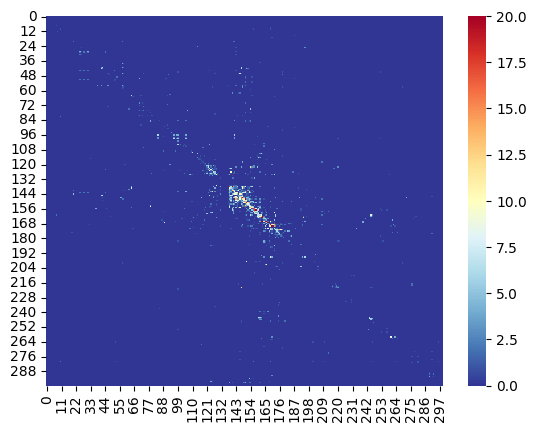

In [114]:
sbn.heatmap(small_dense,vmin=0, vmax=20, cmap="RdYlBu_r")
#print(f'{bins[0]} to {bins[300]}')

In [115]:
#TODO fix from fetch
#bins["bin_id"]


In [116]:
def is_in_window(pixels,start,stop): 
  return (((pixels.bin_1_id >=start) & (pixels.bin_1_id <=stop))&((pixels.bin_1_id >=start) & (pixels.bin_1_id <=stop)))
#view_pixels = final_pixels.loc[is_in_viewpoint(final_pixels, 0,300), ["bin_1_id", "bin_2_id","bin_3_id", "contact_count"]]

In [119]:

view_pixels = final_pixels.loc[is_in_viewpoint(final_pixels, 0,300), ["bin_1_id", "bin_2_id","bin_3_id", "contact_count"]]
save = view_pixels.groupby(["bin_1_id", "bin_2_id"]).sum().reset_index()
count = save.contact_count.to_numpy()
id1 = save.bin_1_id.to_numpy()
id2 = save.bin_2_id.to_numpy()
dense_matrix=coo_matrix((count,(id1, id2)),shape=(save.bin_1_id.max()+1,save.bin_2_id.max()+1 )).toarray()

<AxesSubplot:>

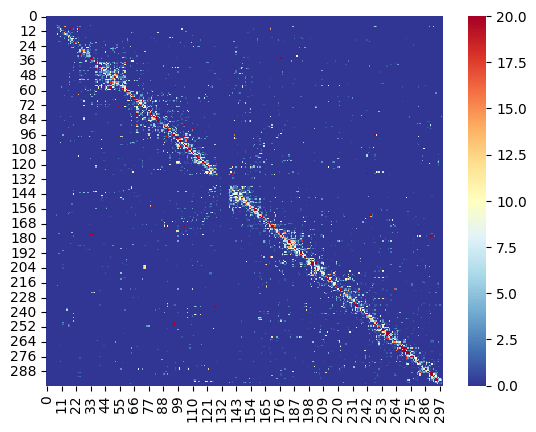

In [120]:
sbn.heatmap(dense_matrix[0:300,0:300],vmin=0, vmax=20, cmap="RdYlBu_r")

In [123]:
def is_trans_at_window(pixels,start,stop): 
  return (((pixels.bin_3_id >=start) & (pixels.bin_3_id <=stop)))

In [146]:
view_pixels = final_pixels.loc[is_trans_at_window(final_pixels, 0,300), ["bin_1_id", "bin_2_id","bin_3_id", "contact_count"]]
view_pixels


,bin_1_id,bin_2_id,bin_3_id,contact_count
1,25,191,189,2
2,25,191,191,1
3,27,25,189,1
4,27,25,191,2
5,76,76,74,2
...,...,...,...,...
4469229,30398,204,206,6
4469230,30398,206,195,1
4470022,30970,194,194,1
4470023,30970,194,195,2


In [145]:
save = view_pixels.groupby(["bin_1_id", "bin_2_id", "bin_3_id"]).sum().reset_index()
line = save.groupby(["bin_3_id"]).sum().reset_index()
line

,bin_3_id,bin_1_id,bin_2_id,contact_count
0,0,146982,146974,8
1,1,136045,136157,7
2,2,23505,12457,1
3,5,63798,62574,3
4,6,61977,39513,4
...,...,...,...,...
288,295,293228,316828,320
289,296,418373,460033,232
290,297,555963,269995,157
291,298,303680,264955,271


<AxesSubplot:xlabel='bin_3_id', ylabel='contact_count'>

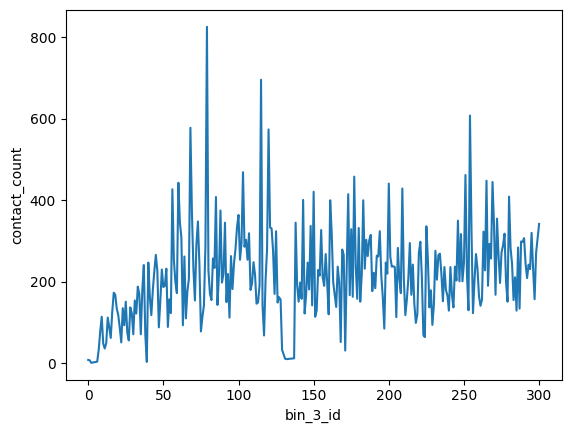

In [143]:
sbn.lineplot(data=line, x="bin_3_id", y="contact_count")